# <b>HAWAIIAN VACATION WEATHER ANALYSIS<b>

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import stats
from statistics import mean

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Review the information in the Measurement table
first_row = session.query(Measurement).first()
# View the query object as a dictionary and view column names and values for a single row
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fa58904630>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
# Review the information in the Station table
first_row = session.query(Station).first()
# View the query object as a dictionary and view column names and values for a single row
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fa58904d30>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar()
last_date

query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year)

# Set the index to the date column
df.set_index('date', inplace=True)

# Rename the column
df.rename(columns = {'prcp':'precipitation'}, inplace = True)

# Sort the dataframe by date
df.sort_index(inplace=True)



C:\Users\reena\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


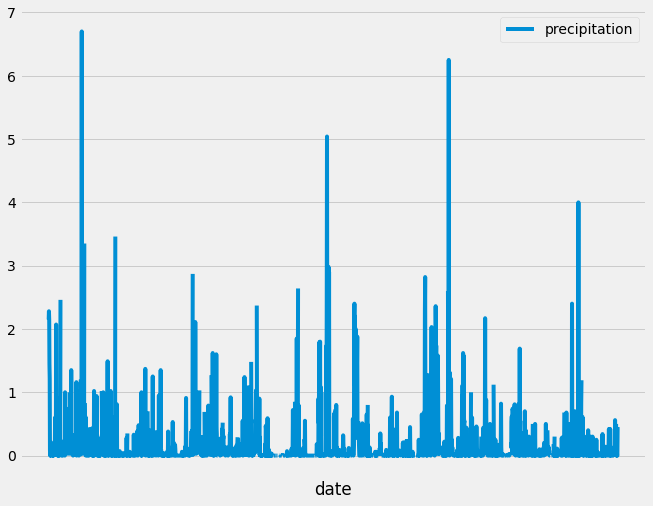

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
ax3 = df.plot(figsize=(10,8))
             
# Suppress the xtick labels by passing an empty list (otherwise it is too crowded with so many dates)
plt.xticks(ticks=[],labels=None)
plt.savefig('Images/PandasPrecipitation.png')
plt.show()

C:\Users\reena\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


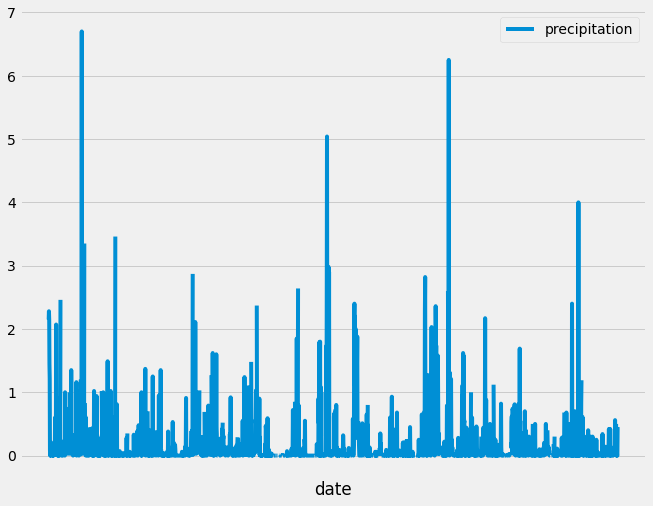

In [14]:
# Using the last date from above perform a query to retrieve the last 12 months of precipitation data
# and the dates and save query results as a Pandas Dataframe - using sqlalchemy method to get data
query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Generate a query object
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Put query object results into a Pandas dataframe
df = pd.DataFrame(last_year)

# Set the index to the date column
df.set_index('date', inplace=True)

# Rename the column
df.rename(columns = {'prcp':'precipitation'}, inplace = True) 
             
# Sort the dataframe by date
df.sort_index(inplace=True)

# Plot the data using pandas.plot method
ax3 = df.plot(figsize=(10,8))
             
# Suppress the xtick labels by passing an empty list (otherwise it is too crowded with so many dates)
plt.xticks(ticks=[],labels=None)
plt.savefig('Images/PandasPrecipitation.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).\
                             group_by(Station.station).count()
print(f'The number of unique stations in this database is: {num_stations}')

The number of unique stations in this database is: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station,func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()
print('The following stations have the most rows in desc order:')
most_active

The following stations have the most rows in desc order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_hi_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
low_hi_avg

(54.0, 85.0, 71.66378066378067)

In [19]:
# Get the last year of temperature observations (tobs) from the most active station and put into
# a Pandas dataframe
last_year_tobs = pd.read_sql("SELECT tobs FROM measurement where \
    station = 'USC00519281' AND date >= DATE('2017-08-23','-12 month')", conn)
#last_year_tobs

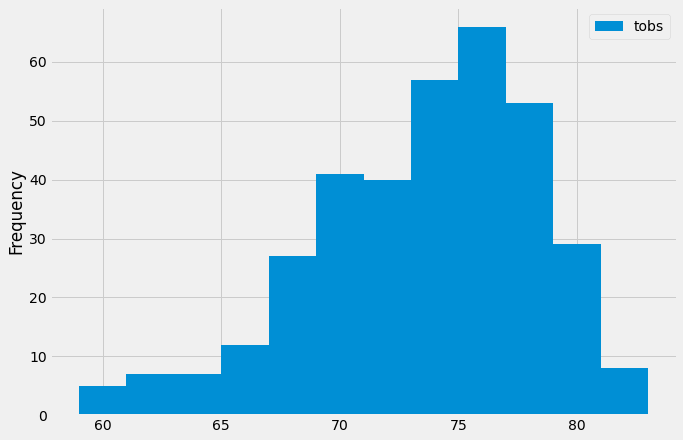

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

last_year_tobs = pd.read_sql("SELECT tobs FROM measurement where \
    station = 'USC00519281' AND date >= DATE('2017-08-23','-12 month')", conn)

# Plot the results as a histogram

num_bins = 12
fig, ax = plt.subplots(figsize=(10,7))

n, bins, patches = ax.hist(last_year_tobs['tobs'], num_bins)

ax.set_ylabel('Frequency')
ax.legend(['tobs'],loc='best')

plt.savefig('Images/Histogram.png')
plt.show()

# Bonus Challenge Assignment

## Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [21]:
# Determine the average temperature for June
june_temps = session.query(Measurement.tobs).\
        filter(Measurement.date.like("%-06-%")).all()
june_avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date.like("%-06-%")).scalar()
print(f"Avg June temp for all stations and all years is: {round(june_avg_temp,2)} F")

Avg June temp for all stations and all years is: 74.94 F


In [22]:
# Determine the average temperature for December
dec_temps = session.query(Measurement.tobs).\
        filter(Measurement.date.like("%-12-%")).all()
dec_avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date.like("%-12-%")).scalar()
print(f"Avg December temp for all stations and all years is: {round(dec_avg_temp,2)} F")

Avg December temp for all stations and all years is: 71.04 F


Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

A paired t-test will be used because the same thing is being measured multiple times.

In [23]:

# Generate function to do a t-test plot pair
def ttestplot(pop1, pop2):
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(pop1)), pop1, label="pop1")
    plt.scatter(range(len(pop2)), pop2, label="pop2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(pop1, 10, density=True, alpha=0.7, label="pop1")
    plt.hist(pop2, 10, density=True, alpha=0.7, label="pop2")
    plt.axvline(mean(pop1), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean(pop2), color='k', linestyle='dashed', linewidth=1)
    plt.savefig('Images/ttest_plot.png')
    plt.legend()

In [24]:
# Convert the list of tuples into a list for each observed month
june_temp_list = [item for t in june_temps for item in t] 
dec_temp_list = [item for t in dec_temps for item in t]

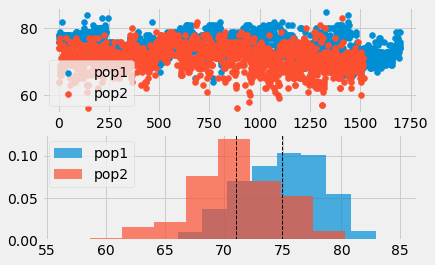

In [25]:
# Call the ttestplot function to visualize the data
ttestplot(june_temp_list,dec_temp_list)

In [26]:
# Run a t-test between the June temps and Dec temps
stats.ttest_ind(june_temp_list,dec_temp_list, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

The t-test has a large F statistic AND a VERY SMALL p value so the June and December average temperatures are statistically different from one another.¶

## Temperature Analysis II

Calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year
Plot the min, avg, and max temperature from your previous query as a bar chart.
Use the average temperature as the bar height.
Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2010-02-28', '2010-03-05'))

[(63.0, 68.47727272727273, 73.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max = calc_temps('2017-02-22', '2017-03-01')
min_avg_max

[(61.0, 69.6923076923077, 77.0)]

In [29]:
#Store the information in a data frame
trip_temp_df = pd.DataFrame(min_avg_max, columns=["Min Temp.", "Avg Temp.", "Max Temp."])
trip_temp_df

,Min Temp.,Avg Temp.,Max Temp.
0,61.0,69.692308,77.0


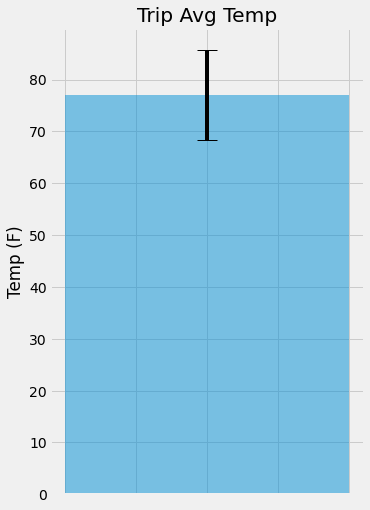

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#Calculate the error
tmin = 61
tmax = 69.7
tavg = 77
error = tmax-tmin

# Plot the bar using the error
fig, ax = plt.subplots(figsize=(5,8))
ax.bar(1,tavg, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_xticklabels([])
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.savefig('Images/bar_plot_with_error_bars.png')
plt.show()

## Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_station = pd.read_sql("SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'Total Rainfall'\
                            FROM station s\
                            JOIN measurement m ON(s.station = m.station)\
                            WHERE m.date BETWEEN '2017-02-22' AND '2017-03-01'\
                            GROUP BY s.station\
                            ORDER BY SUM(m.prcp) DESC" , conn)
rain_station.head(10)

,station,name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.02
1,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.57
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.42
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.22
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.29
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.27
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.72


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# trip dates 
trip_dates = ['02-22','02-23','02-24','02-25','02-26','02-27','02-28','03-01']


# push each tuple of calculations into a list called `normals`
normals =[]

# Set the start and end date of the trip
start_vacation = dt.date(2018,2,22)

numdays = 8


In [34]:
# Strip off the year and save a list of %m-%d strings
date_list = [str(start_vacation + dt.timedelta(days=x))[5:] for x in range(numdays)]
print(date_list)

['02-22', '02-23', '02-24', '02-25', '02-26', '02-27', '02-28', '03-01']


In [35]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(month_day) for month_day in date_list]
normals

[[(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)],
 [(61.0, 68.56666666666666, 76.0)],
 [(61.0, 68.59649122807018, 76.0)],
 [(62.0, 69.89285714285714, 78.0)],
 [(58.0, 69.98148148148148, 77.0)],
 [(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)]]

In [36]:
# using list comprehension 
# convert list of tuples to list of list 
normals_list = [list(elements) for elements in normals]
normals_list

[[(60.0, 70.15789473684211, 83.0)],
 [(62.0, 70.35593220338983, 81.0)],
 [(61.0, 68.56666666666666, 76.0)],
 [(61.0, 68.59649122807018, 76.0)],
 [(62.0, 69.89285714285714, 78.0)],
 [(58.0, 69.98148148148148, 77.0)],
 [(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)]]

In [ ]:
#Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
normal_temp_df = pd.DataFrame(normals_list,columns=['tmin','tavg','tmax']).rename_axis('date')
normal_temp_df.head()


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
normal_temp_df.plot.area(stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()